# Init Bionic VTOL

In [217]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

create_visualization();

# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8718
└ @ MeshCat C:\Users\leevi\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


1

# Create Reinforcement Learning Environment

In [218]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environments
    visualization::Bool # visualization
    realtime::Bool # realtime

    x_previous::Vector{T} # current position
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # simulation time step

    ################################ TODO ################################
    # Extend the environment here.
    # Everything you need additionaly in your environment also go in here.
    # E.g. a trajectory

    waypoints::Vector{Vector{T}} # waypoints
    proximity_tolerance::T # proximity tolerance
    max_v::T # maximum allowed velocity
    ######################################################################
end

################################ TODO ################################
# You can initialization global constants here.
# E.g. a fixed point in the beginning of training (for testing/overfitting)
# Define global constants for initial position and rotation
const INITIAL_POSITION = [0.0, 0.0, 0.0];
const INITIAL_ROTATION = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0];
const SAMPLE_WAYPOINTS = [[0.0, 0.0, 0.0],[35.0, 0.0, 20.0]]
######################################################################


2-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [35.0, 0.0, 20.0]

In [219]:
# define a keyword-based constructor for the type declared in the mutable struct typedef.
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs...) # let the function take an arbitrary number of keyword arguments
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    A = Space{Vector{ClosedInterval{T}}};

    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ],
    ) # propeller 1 and 2
    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            ################################ TODO ################################
            # Implement an observation space. 
            # Here is an example space. You can change it if desired.
            # You have to extend it.
            # Orientate yourself on the observation space from the paper.
            
            typemin(T)..typemax(T), # previous position along x WORLD coordinates
            typemin(T)..typemax(T), # previous position along z WORLD coordinates

            typemin(T)..typemax(T), # current position along x WORLD coordinates
            typemin(T)..typemax(T), # current position along z WORLD coordinates
            
            typemin(T)..typemax(T), # orientation along x WORLD coordinates
            typemin(T)..typemax(T), # orientation along z WORLD coordinates
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates

            typemin(T)..typemax(T), # position of target along x WORLD coordinates
            typemin(T)..typemax(T), # position of target along y WORLD coordinates

            ######################################################################
            ], 
    )
    
    if visualization #visualizes VTOL
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space, # action space
        state_space, # observation space
        zeros(T, length(state_space)), # current state space
        rand(action_space), # initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_previous, previous position
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # simulation time step

        ################################## TODO ##################################
        # Initialization everything you need additionaly in your environment here.
        SAMPLE_WAYPOINTS,
        1e-5, # proximity tolerance
        100.0, # final time
        
        ##########################################################################
    )
    
    
    reset!(environment)
    
    return environment
    
end;

methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at c:\Users\leevi\Codes\NN project\nn_project_drone\code\src\steer_to_point_2d\steer_to_point_2d.ipynb:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_previous::Vector{T}, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, waypoints::Array{Vector{T}, 1}, proximity_tolerance::T, max_v::T) where {A, T, ACT, R<:AbstractRNG} in Main at c:\Users\leevi\Codes\NN project\nn_project_drone\code\src\steer_to_point_2d\steer_to_point_2d.ipynb:2

Just for explanation:
1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.'
So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

# Define the RL interface

In [220]:
test = "eth_vtol_param"
println(test)

eth_vtol_param


In [221]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

global HYPERPARAMETER_KP = 1.0;
global HYPERPARAMETER_KWP = 1.0;
global HYPERPARAMETER_OMG = 1.0;
function computeReward(env::VtolEnv{A,T}) where {A,T}

    ################################ TODO ################################
    # Implement the reward function.
    # Orientate on the paper.
    
    gates = env.waypoints;
    n = length(gates);

    #=
    function compute_distance(position::Vector{T})
        l_min_index, phi_l = calculate_progress(gates, position);
        reached_distance = 0.0;
        for i in 1:(l_min_index-1)
            reached_distance += (abs(gates[i+1] - gates[i]) + abs(phi_l - gates[l]));
        end
        return reached_distance;
    end
    =#

    function rp(position::Vector{T}) #Reward für Annäherung an den Zielpunkt
        rp=(norm(gates[1]-env.x_previous)-norm(gates[1]-position))/0.025; #/env.Δt;
        return rp;
    end

    #=
    reached_distance_previous = compute_distance(env.x_previous);
    reached_distance_current = compute_distance(env.x_W); 
    progress_reward = reached_distance_current - reached_distance_previous; 
    =#
    
    function computate_reached_target(position::Vector{T}) #reward für erreichten Zielpunkt
        rW =   exp(-norm(gates[1] - position)/env.proximity_tolerance); 
        # eins bei erreichtem Zielpunkt, fällt exponentiell mit dem Abstand
        return rW;
    end
    

    bodyrates = norm(env.ω_B)
    target_reward = computate_reached_target(env.x_W)
    progress_reward = rp(env.x_W)

    function compute_ks()
        factor = 2 * env.Δt * env.max_v;
        sum = 0.0;
        for i in 1:(n-1)
            sum += abs(gates[i+1] - gates[i]);
        end
        return factor / sum;
        
    end
    
    reward = (HYPERPARAMETER_KP*progress_reward + HYPERPARAMETER_KWP*target_reward) #- HYPERPARAMETER_OMG*bodyrates
    # Δt
    ################################################################################################

    return reward
end

RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end

    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    ################################ TODO ################################
    # Reset environment.
    # Is called if the training terminates
    # (e.g. if drone crashes or successfully reaches point)
    # HINT: Everything you added to your environment needs to be reseted.
    #       Compare it with the initialization.

    env.x_previous = [0.0; 0.0; 0.0]; # starting position
    env.Δt=0.0; # Δ time                                    Why does this have to be 0????

    env.waypoints = generate_trajectory(2);
    env.proximity_tolerance = 1e-5;
    ######################################################################

    nothing
end;

# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    # flaps set to 0.0
    next_action = [a[1], a[2], 0.0, 0.0]

    _step!(env, next_action)
end

In [222]:
env = VtolEnv();
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at c:\Users\leevi\Codes\NN project\nn_project_drone\code\src\steer_to_point_2d\steer_to_point_2d.ipynb:109
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [223]:
function _step!(env::VtolEnv, next_action)

    ################################ TODO ################################
    # Implement step.
    # HINT: This is relatet to your environment.
    #       Compare to struct VtolEnv.
    #       How does it change in every step.

    env.state[1] = env.state[3]; # update previous x-coordinate
    env.state[2] = env.state[4]; # update previous z-coordinate
    env.x_previous = env.x_W;

    ######################################################################

    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W);

    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);

    # Limit to 2D
    force_B[2] = 0.0; # Body Z
    env.v_B[2] = 0.0;
    torque_B[1] = 0.0;
    torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0;
    env.ω_B[2] = 0.0;

    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param);

    if env.realtime
        sleep(env.Δt); # just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action);
    end

    env.t += env.Δt

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.R_W[1,1]; # orientation along x
    env.state[6] = env.R_W[3,1]; # orientation along z

    env.state[7] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[8] = env.v_B[3]; # velocity along y BODY coordinates

    env.state[9] = env.ω_B[3];  # rotational velocity along z BODY coordinates

    ################################ TODO ################################
    # Implement step.
    # HINT: This is relatet to your environment.
    #       Compare to struct VtolEnv.
    #       How does it change in every step.

    env.state[10] = env.waypoints[1][1] - env.x_W[1] # position of target along x WORLD coordinates
    env.state[11] = env.waypoints[1][3] - env.x_W[3] # position of target along z WORLD coordinates
    ######################################################################


    ################################ TODO ################################
    # Add termination criterias.
    # Use many termination criteria so that you do not train unnecessarily in wrong areas.
    env.done =
        norm(env.ω_B) > 100.0 || # stop if body rate is too high
        norm(env.v_B) > env.max_v || # stop if body is too fast
        norm(env.waypoints[1] - env.x_W) < env.proximity_tolerance || # target reached
        env.t > 10 || # taking too long
    ######################################################################

    nothing
end;

RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  0.0s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.674676091049e9, 1.674676091062e9)

changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)
Show an overview of the environment.
# Setup of a reinforcement learning experiment.

In [224]:
seed = 123
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024

    vtol_envs = [
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ];
    # define multiple environments for parallel training
    env = MultiThreadEnv(vtol_envs)

    # Define the function approximator
    # (optional) TODO: change architecture
    # TODO: research briefly what Actor Critic is
    # (optional) TODO: change optimizer
    # TODO: research what ADAM is
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, tanh; initW = glorot_uniform(rng)),#
                    Dense(16, 16, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, tanh; initW = glorot_uniform(rng)),
                    Dense(16, 16, tanh; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

        agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # (optional) TODO: change eventually
        # TODO: research briefly what PPO is
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),

        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


In [225]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./examples/RL_models/", "vtol_2D_ppo_$t.bson") # TODO: save model here
    @save f model
    println("parameters at step $t saved to $f")
end;

function loadModel()
    f = joinpath("./examples/RL_models/", "vtol_2D_ppo_1500000.bson") # TODO: load model here
    @load f model
    return model
end;

function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")

end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

#agent.policy.approximator = loadModel();

# VtolEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[-Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf, -Inf..Inf])`

## Action Space

`Space{Vector{ClosedInterval{Float64}}}(ClosedInterval{Float64}[0.0..2.0, 0.0..2.0])`

## Current State

```
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```


In [226]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(100_000),
    ComposedHook(
        #DoEveryNStep(saveModel, n=100_000),                    # doesn't work for some reason.   TODO: fix it
        DoEveryNStep(validate_policy, n=10_000)),
)

CompositeException: TaskFailedException

    nested task error: MethodError: Cannot `convert` an object of type Nothing to an object of type Bool
    Closest candidates are:
      convert(::Type{T}, !Matched::Ptr) where T<:Integer at pointer.jl:23
      convert(::Type{IT}, !Matched::GeometryBasics.OffsetInteger) where IT<:Integer at C:\Users\leevi\.julia\packages\GeometryBasics\pjtu1\src\offsetintegers.jl:40
      convert(::Type{<:Integer}, !Matched::CUDA.CUSPARSE.cusparseIndexBase_t) at C:\Users\leevi\.julia\packages\CUDA\DfvRa\lib\cusparse\types.jl:42
      ...
    Stacktrace:
     [1] setproperty!(x::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}, f::Symbol, v::Nothing)
       @ Base .\Base.jl:39
     [2] _step!(env::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}, next_action::Vector{Float64})
       @ Main c:\Users\leevi\Codes\NN project\nn_project_drone\code\src\steer_to_point_2d\steer_to_point_2d.ipynb:69
     [3] (::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG})(a::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true})
       @ Main c:\Users\leevi\Codes\NN project\nn_project_drone\code\src\steer_to_point_2d\steer_to_point_2d.ipynb:114
     [4] macro expansion
       @ C:\Users\leevi\.julia\packages\ReinforcementLearningZoo\tvfq9\src\algorithms\policy_gradient\multi_thread_env.jl:91 [inlined]
     [5] (::ReinforcementLearningZoo.var"#130#131"{MultiThreadEnv{VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}, Matrix{Float64}, Vector{Float64}, Space{Matrix{ClosedInterval{Float64}}}, Space{Matrix{ClosedInterval{Float64}}}, Nothing}, Matrix{Float64}, Int64, Int64})()
       @ ReinforcementLearningZoo .\threadingconstructs.jl:258

...and 7 more exceptions.


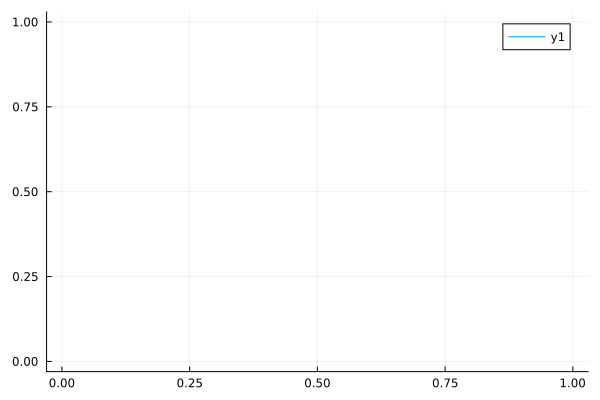

In [227]:
plot(episode_test_reward_hook.rewards)

In [228]:
close_visualization(); # closes the MeshCat visualization